### Introduction

This project is devoted to the question-answering task - the **BoolQ** dataset from SuperGLUE .

BoolQ is a question answering dataset for yes/no.


    Example:
    
    {
      "question": "is france the same timezone as the uk",
      "passage": "At the Liberation of France in the summer of 1944, Metropolitan France kept GMT+2 as it was the time then used by the Allies (British Double Summer Time). In the winter of 1944--1945, Metropolitan France switched to GMT+1, same as in the United Kingdom, and switched again to GMT+2 in April 1945 like its British ally. In September 1945, Metropolitan France returned to GMT+1 (pre-war summer time), which the British had already done in July 1945. Metropolitan France was officially scheduled to return to GMT+0 on November 18, 1945 (the British returned to GMT+0 in on October 7, 1945), but the French government canceled the decision on November 5, 1945, and GMT+1 has since then remained the official time of Metropolitan France."
      "label": false,
      "idx": 123,
    }


Dataset is available here: https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip

Detailed task description is available here: https://arxiv.org/abs/1905.10044




# 1) Training data



### Data analysis




In [1]:
# === Basic Imports ===
import os
import json
import random
import time
from collections import Counter

# === Data Analysis and Visualization ===
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# === NLTK for Text Processing ===
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# === Gensim for Word Embeddings ===
import gensim.downloader as api
from gensim.models import KeyedVectors

# === NumPy ===
import numpy as np

# === Transformers for NLP ===
from transformers import (
    DistilBertTokenizer,
    DistilBertModel,
    DistilBertForSequenceClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW,
    get_scheduler,
)

# === PyTorch ===
import torch
from torch.utils.data import DataLoader, TensorDataset

# === Sklearn for Model Evaluation ===
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === TQDM for Progress Bars ===
from tqdm.notebook import tqdm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
boolq_url = "https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip"

# download dataset
!wget -O BoolQ.zip {boolq_url}
!unzip -o BoolQ.zip

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# load
train_data = load_jsonl("BoolQ/train.jsonl")
val_data = load_jsonl("BoolQ/val.jsonl")

# combine data
all_data = train_data + val_data


--2024-12-14 08:53:04--  https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.102, 108.157.254.124, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4118001 (3.9M) [application/zip]
Saving to: ‘BoolQ.zip’

BoolQ.zip           100%[===================>]   3.93M  3.55MB/s    in 1.1s    

2024-12-14 08:53:06 (3.55 MB/s) - ‘BoolQ.zip’ saved [4118001/4118001]

Archive:  BoolQ.zip
   creating: BoolQ/
  inflating: BoolQ/train.jsonl       
  inflating: BoolQ/test.jsonl        
  inflating: BoolQ/val.jsonl         


### Visualize

In [ ]:
# function to calc statistics
def calculate_statistics(data):
    stats = {
        "total_examples": len(data),
        "class_distribution": Counter([entry['label'] for entry in data]),
        "mean_sentence_length_question": sum(len(word_tokenize(entry['question'])) for entry in data) / len(data),
        "mean_sentence_length_passage": sum(len(word_tokenize(entry['passage'])) for entry in data) / len(data),
        "unique_words_question": len(set(word for entry in data for word in word_tokenize(entry['question']))),
        "unique_words_passage": len(set(word for entry in data for word in word_tokenize(entry['passage']))),
    }
    return stats

# function to print statistics nicely
def display_statistics(stats):
    print("\n" + "="*50)
    print("Dataset Statistics")
    print("="*50)

    # organize data
    stats_df = pd.DataFrame({
        "Statistic": [
            "Total Examples",
            "Class Distribution (True)",
            "Class Distribution (False)",
            "Mean Sentence Length (Question)",
            "Mean Sentence Length (Passage)",
            "Unique Words (Question)",
            "Unique Words (Passage)"
        ],
        "Value": [
            stats["total_examples"],
            stats["class_distribution"].get(True, 0),
            stats["class_distribution"].get(False, 0),
            round(stats["mean_sentence_length_question"], 2),
            round(stats["mean_sentence_length_passage"], 2),
            stats["unique_words_question"],
            stats["unique_words_passage"]
        ]
    })

    # display as a table
    print(stats_df.to_string(index=False))
    print("="*50)

stats = calculate_statistics(all_data)
display_statistics(stats)



Dataset Statistics
                      Statistic    Value
                 Total Examples 12697.00
      Class Distribution (True)  7907.00
     Class Distribution (False)  4790.00
Mean Sentence Length (Question)     8.83
 Mean Sentence Length (Passage)   112.22
        Unique Words (Question) 10504.00
         Unique Words (Passage) 63495.00


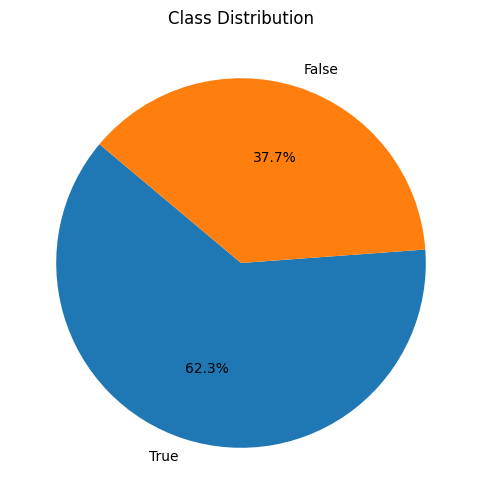

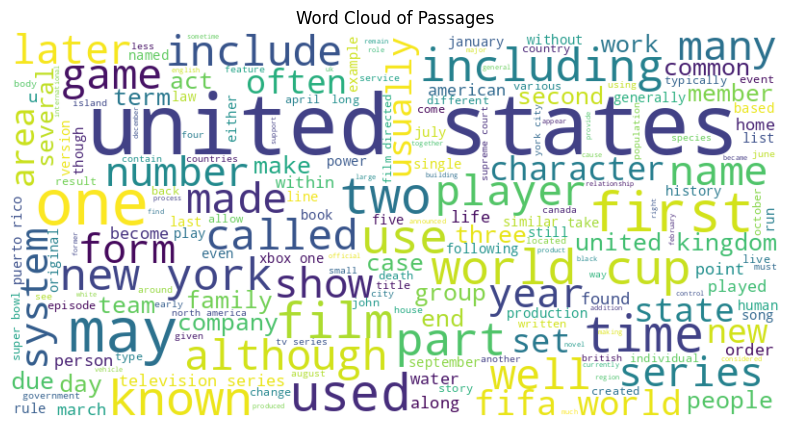

In [ ]:
def visualize_statistics(stats):
    # class distribution - graph
    labels = ['True', 'False']
    sizes = [stats['class_distribution'][True], stats['class_distribution'][False]]
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Class Distribution')
    plt.show()

    # word cloud - passages
    stop_words = set(stopwords.words('english'))
    text = " ".join([entry['passage'] for entry in all_data])
    text = " ".join([word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Passages')
    plt.show()

visualize_statistics(stats)

# 2) Model


### Fine-tune BERT




In [3]:
# split train_data into train and dev (90% train, 10% dev)
train_data_split, dev_data_split = train_test_split(
    train_data, test_size=0.1, random_state=42
)

print(f"Training set size: {len(train_data_split)}")
print(f"Development set size: {len(dev_data_split)}")

# tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_data(data):
    """
    Tokenize BoolQ data with question and passage.
    """
    input_ids, attention_masks, labels = [], [], []
    for entry in data:
        combined_text = entry["question"] + " [SEP] " + entry["passage"]
        tokenized = tokenizer(
            combined_text,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        input_ids.append(tokenized["input_ids"].squeeze())
        attention_masks.append(tokenized["attention_mask"].squeeze())
        labels.append(int(entry["label"]))  # Convert label to integer
    return (
        torch.stack(input_ids),
        torch.stack(attention_masks),
        torch.tensor(labels, dtype=torch.long),
    )

# tokenize and format train and dev datasets
train_inputs, train_masks, train_labels = preprocess_data(train_data_split)
dev_inputs, dev_masks, dev_labels = preprocess_data(dev_data_split)


Training set size: 8484
Development set size: 943


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

I will use DistilBERT with a classification head as this task involves binary classification. Setting `num_labels=2` configures the model for binary classification (True/False).

- `Learning Rate`: 2e-5 for stable fine-tuning of pre-trained models.
- `Optimizer`: AdamW with weight_decay=0.01 to reduce overfitting.

- A `linear scheduler` gradually decreases the learning rate over the training steps.
  - `num_warmup_steps=100` warms up the learning rate to allow the model to stabilize before aggressive optimization.
  - `num_training_steps` should match the total number of training steps in your loop (adjust as necessary).

In [10]:
# TensorDataset and DataLoader
batch_size = 16

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
dev_dataset = TensorDataset(dev_inputs, dev_masks, dev_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(dev_dataset, batch_size=batch_size)

# model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
model.to(device)

# optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 10
total_steps = len(train_dataloader) * epochs

scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


* Training loop and fine-tune BERT.

**Source:** https://mccormickml.com/2019/07/22/BERT-fine-tuning/



In [11]:
## SOURCE: https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=6O_NbXFGMukX

# Function to format time
def format_time(elapsed):
    """
    Converts a time in seconds to a string in hh:mm:ss format.
    """
    elapsed_rounded = int(round(elapsed))
    return str(time.strftime("%H:%M:%S", time.gmtime(elapsed_rounded)))

# Function to calculate flat accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [12]:
## SOURCE: https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=6O_NbXFGMukX

# Training and evaluation loop
def train_and_evaluate():
    training_stats = []  # Initialize the list to store stats
    total_t0 = time.time()

    for epoch_i in range(epochs):
        # Training phase
        print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
        print("Training...")

        t0 = time.time()
        total_train_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step % 100 == 0 and step > 0:
                elapsed = format_time(time.time() - t0)
                print(f"  Batch {step:>5} of {len(train_dataloader)}. Elapsed: {elapsed}")

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            result = model(
                b_input_ids, attention_mask=b_input_mask, labels=b_labels
            )
            loss = result.loss
            logits = result.logits

            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        training_time = format_time(time.time() - t0)
        print(f"  Average training loss: {avg_train_loss:.2f}")
        print(f"  Training epoch took: {training_time}")

        # Validation phase
        print("\nRunning Validation...")
        t0 = time.time()
        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0

        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                result = model(
                    b_input_ids, attention_mask=b_input_mask, labels=b_labels
                )
                loss = result.loss
                logits = result.logits

            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        validation_time = format_time(time.time() - t0)

        print(f"  Validation Loss: {avg_val_loss:.2f}")
        print(f"  Validation Accuracy: {avg_val_accuracy:.2f}")
        print(f"  Validation took: {validation_time}")

        # Append epoch statistics to the list
        training_stats.append(
            {
                "epoch": epoch_i + 1,
                "Training Loss": avg_train_loss,
                "Validation Loss": avg_val_loss,
                "Validation Accuracy": avg_val_accuracy,
                "Training Time": training_time,
                "Validation Time": validation_time,
            }
        )

    print("\nTraining complete!")
    print(f"Total training took {format_time(time.time() - total_t0)}")

    # Return the training stats
    return training_stats

# Call the function and store the training statistics
training_stats = train_and_evaluate()


======== Epoch 1 / 10 ========
Training...
  Batch   100 of 531. Elapsed: 00:00:18
  Batch   200 of 531. Elapsed: 00:00:36
  Batch   300 of 531. Elapsed: 00:00:53
  Batch   400 of 531. Elapsed: 00:01:11
  Batch   500 of 531. Elapsed: 00:01:29
  Average training loss: 0.64
  Training epoch took: 00:01:34

Running Validation...
  Validation Loss: 0.60
  Validation Accuracy: 0.68
  Validation took: 00:00:03

======== Epoch 2 / 10 ========
Training...
  Batch   100 of 531. Elapsed: 00:00:18
  Batch   200 of 531. Elapsed: 00:00:35
  Batch   300 of 531. Elapsed: 00:00:53
  Batch   400 of 531. Elapsed: 00:01:10
  Batch   500 of 531. Elapsed: 00:01:28
  Average training loss: 0.55
  Training epoch took: 00:01:33

Running Validation...
  Validation Loss: 0.58
  Validation Accuracy: 0.70
  Validation took: 00:00:03

======== Epoch 3 / 10 ========
Training...
  Batch   100 of 531. Elapsed: 00:00:18
  Batch   200 of 531. Elapsed: 00:00:35
  Batch   300 of 531. Elapsed: 00:00:52
  Batch   400 of 5

**As training loss decreases, the rising validation loss shows the model is overfitting, learning patterns specific to the training data that dont generalize well.**

**Validation loss is more informative than accuracy because it considers prediction confidence. Accuracy only checks if predictions are correct, but validation loss detects when confidence drops, even if predictions are accurate.**

In [13]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.641743176569373,
  'Validation Loss': 0.6031388963683176,
  'Validation Accuracy': 0.6776836158192091,
  'Training Time': '00:01:34',
  'Validation Time': '00:00:03'},
 {'epoch': 2,
  'Training Loss': 0.5527675978544742,
  'Validation Loss': 0.5841989835440102,
  'Validation Accuracy': 0.7008474576271186,
  'Training Time': '00:01:33',
  'Validation Time': '00:00:03'},
 {'epoch': 3,
  'Training Loss': 0.4213328698962197,
  'Validation Loss': 0.6598760975619494,
  'Validation Accuracy': 0.6987994350282486,
  'Training Time': '00:01:33',
  'Validation Time': '00:00:03'},
 {'epoch': 4,
  'Training Loss': 0.2840607096484938,
  'Validation Loss': 0.8451560462935496,
  'Validation Accuracy': 0.6977401129943502,
  'Training Time': '00:01:33',
  'Validation Time': '00:00:03'},
 {'epoch': 5,
  'Training Loss': 0.20480085256213074,
  'Validation Loss': 1.1007412136611292,
  'Validation Accuracy': 0.6967514124293785,
  'Training Time': '00:01:33',
  'Validation 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display floats with two decimal places.
pd.options.display.precision = 2

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Check if 'epoch' exists in columns
print("Columns in DataFrame:", df_stats.columns)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

Columns in DataFrame: Index(['epoch', 'Training Loss', 'Validation Loss', 'Validation Accuracy',
       'Training Time', 'Validation Time'],
      dtype='object')


,Training Loss,Validation Loss,Validation Accuracy,Training Time,Validation Time
epoch,,,,,
1,0.64,0.60,0.68,00:01:34,00:00:03
2,0.55,0.58,0.70,00:01:33,00:00:03
3,0.42,0.66,0.70,00:01:33,00:00:03
4,0.28,0.85,0.70,00:01:33,00:00:03
5,0.20,1.10,0.70,00:01:33,00:00:03
6,0.15,1.46,0.69,00:01:33,00:00:03
7,0.11,1.52,0.70,00:01:33,00:00:03
8,0.08,1.56,0.70,00:01:33,00:00:03
9,0.06,1.75,0.70,00:01:32,00:00:03


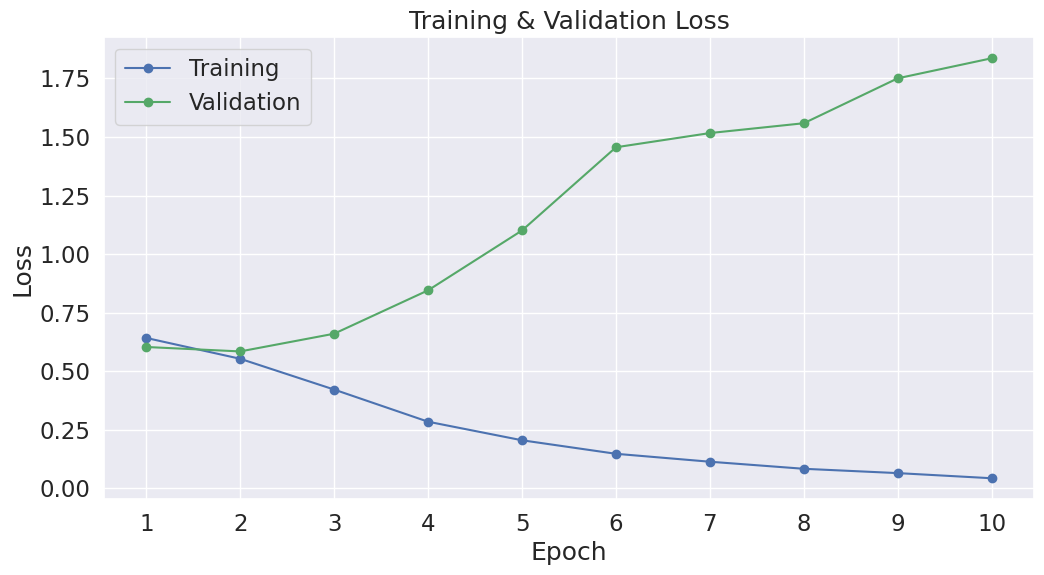

In [15]:
# Plot the learning curve
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(df_stats["Training Loss"], "b-o", label="Training")
plt.plot(df_stats["Validation Loss"], "g-o", label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(df_stats.index)

plt.show()

* Make predictions for the test data (from `val.jsonl`),  and analyze the results (use accuracy metric for scoring).





In [16]:
test_data = load_jsonl("BoolQ/val.jsonl")

test_inputs, test_masks, test_labels = preprocess_data(test_data)

# DataLoader for the test data
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Function to make predictions on test data
def evaluate_test_set(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Forward pass
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits

            # Get the predicted labels
            preds = torch.argmax(logits, axis=1).detach().cpu().numpy()
            labels = b_labels.cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)

    return predictions, true_labels

# vake predictions on test set
predictions, true_labels = evaluate_test_set(model, test_dataloader)

# calculate accuracy
test_accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

def analyze_results(predictions, true_labels):
    total = len(true_labels)
    correct = np.sum(np.array(predictions) == np.array(true_labels))
    print(f"Total samples: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Incorrect predictions: {total - correct}")

# call the analysis function
analyze_results(predictions, true_labels)

Test Accuracy: 0.71
Total samples: 3270
Correct predictions: 2313
Incorrect predictions: 957


In [17]:
# Save the model
model_save_path = "saved_model"
tokenizer_save_path = "saved_tokenizer"

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Model saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")

Model saved to saved_model
Tokenizer saved to saved_tokenizer


In [27]:
!zip -r saved_model.zip saved_model
from google.colab import files
files.download("saved_model.zip")


  adding: saved_model/ (stored 0%)
  adding: saved_model/config.json (deflated 46%)
  adding: saved_model/model.safetensors (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
!zip -r saved_tokenizer.zip saved_tokenizer
from google.colab import files
files.download("saved_tokenizer.zip")


  adding: saved_tokenizer/ (stored 0%)
  adding: saved_tokenizer/vocab.txt (deflated 53%)
  adding: saved_tokenizer/tokenizer.json (deflated 71%)
  adding: saved_tokenizer/tokenizer_config.json (deflated 76%)
  adding: saved_tokenizer/special_tokens_map.json (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3) MLOps

### WandB (Weights & Biases)

In [20]:
!pip install mlflow
!pip install wandb
!pip install requests

In [28]:
import wandb

# Initialize WandB
wandb.init(
    project="boolq-question-answering",  # project name
    name="distilbert_boolq_run",         # Name of run
    config={                             # Log hyperparameters
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": 2e-5,
        "model": "distilbert-base-uncased"
    },
)

# Update training and evaluation loop to log metrics
def train_and_evaluate_with_wandb():
    training_stats = []
    total_t0 = time.time()

    for epoch_i in range(epochs):
        print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
        print("Training...")

        t0 = time.time()
        total_train_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step % 40 == 0 and step > 0:
                elapsed = format_time(time.time() - t0)
                print(f"  Batch {step:>5} of {len(train_dataloader)}. Elapsed: {elapsed}")

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            result = model(
                b_input_ids, attention_mask=b_input_mask, labels=b_labels
            )
            loss = result.loss
            logits = result.logits

            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        training_time = format_time(time.time() - t0)
        print(f"  Average training loss: {avg_train_loss:.2f}")
        print(f"  Training epoch took: {training_time}")

        # Log training loss to WandB
        wandb.log({"train_loss": avg_train_loss, "epoch": epoch_i + 1})

        # Validation phase
        print("\nRunning Validation...")
        t0 = time.time()
        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0

        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                result = model(
                    b_input_ids, attention_mask=b_input_mask, labels=b_labels
                )
                loss = result.loss
                logits = result.logits

            total_eval_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        validation_time = format_time(time.time() - t0)

        print(f"  Validation Loss: {avg_val_loss:.2f}")
        print(f"  Validation Accuracy: {avg_val_accuracy:.2f}")
        print(f"  Validation took: {validation_time}")

        # Log validation metrics to WandB
        wandb.log(
            {
                "val_loss": avg_val_loss,
                "val_accuracy": avg_val_accuracy,
                "epoch": epoch_i + 1,
            }
        )

        # Append epoch statistics to the list
        training_stats.append(
            {
                "epoch": epoch_i + 1,
                "Training Loss": avg_train_loss,
                "Validation Loss": avg_val_loss,
                "Validation Accuracy": avg_val_accuracy,
                "Training Time": training_time,
                "Validation Time": validation_time,
            }
        )

    print("\nTraining complete!")
    print(f"Total training took {format_time(time.time() - total_t0)}")

    # Save model and log it as an artifact in WandB
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(tokenizer_save_path)
    wandb.save(f"{model_save_path}/*")
    print(f"Model saved and logged to WandB.")

    return training_stats

# Call the WandB-enhanced training function
training_stats = train_and_evaluate_with_wandb()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



======== Epoch 1 / 10 ========
Training...
  Batch    40 of 531. Elapsed: 00:00:07
  Batch    80 of 531. Elapsed: 00:00:14
  Batch   120 of 531. Elapsed: 00:00:21
  Batch   160 of 531. Elapsed: 00:00:28
  Batch   200 of 531. Elapsed: 00:00:36
  Batch   240 of 531. Elapsed: 00:00:43
  Batch   280 of 531. Elapsed: 00:00:50
  Batch   320 of 531. Elapsed: 00:00:57
  Batch   360 of 531. Elapsed: 00:01:04
  Batch   400 of 531. Elapsed: 00:01:11
  Batch   440 of 531. Elapsed: 00:01:18
  Batch   480 of 531. Elapsed: 00:01:25
  Batch   520 of 531. Elapsed: 00:01:32
  Average training loss: 0.04
  Training epoch took: 00:01:34

Running Validation...
  Validation Loss: 1.84
  Validation Accuracy: 0.70
  Validation took: 00:00:03

======== Epoch 2 / 10 ========
Training...
  Batch    40 of 531. Elapsed: 00:00:07
  Batch    80 of 531. Elapsed: 00:00:14
  Batch   120 of 531. Elapsed: 00:00:21
  Batch   160 of 531. Elapsed: 00:00:28
  Batch   200 of 531. Elapsed: 00:00:35
  Batch   240 of 531. Elaps

wandb: WARNING Symlinked 2 files into the W&B run directory, call wandb.save again to sync new files.


Model saved and logged to WandB.


In [29]:
# Evaluate on the test set
predictions, true_labels = evaluate_test_set(model, test_dataloader)
test_accuracy = accuracy_score(true_labels, predictions)

# Log test accuracy to WandB
wandb.log({"test_accuracy": test_accuracy})

print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.71


In [31]:
# Set new hyperparameters
epochs = 4
learning_rate = 2e-4

# Initialize WandB
wandb.init(
    project="boolq-question-answering",
    name="distilbert_boolq_4_epochs_lr_2e-4",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "model": "distilbert-base-uncased",
    },
)

# Update optimizer with the new learning rate
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

# Run training and evaluation
training_stats = train_and_evaluate_with_wandb()



epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
test_accuracy,▁
train_loss,▃▇▅▄▆▁▅█▄▃
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.70734
train_loss,0.03649
val_accuracy,0.69788
val_loss,1.83611


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 4 ========
Training...
  Batch    40 of 531. Elapsed: 00:00:07
  Batch    80 of 531. Elapsed: 00:00:14
  Batch   120 of 531. Elapsed: 00:00:21
  Batch   160 of 531. Elapsed: 00:00:28
  Batch   200 of 531. Elapsed: 00:00:36
  Batch   240 of 531. Elapsed: 00:00:43
  Batch   280 of 531. Elapsed: 00:00:50
  Batch   320 of 531. Elapsed: 00:00:57
  Batch   360 of 531. Elapsed: 00:01:04
  Batch   400 of 531. Elapsed: 00:01:10
  Batch   440 of 531. Elapsed: 00:01:17
  Batch   480 of 531. Elapsed: 00:01:24
  Batch   520 of 531. Elapsed: 00:01:31
  Average training loss: 0.68
  Training epoch took: 00:01:33

Running Validation...
  Validation Loss: 0.68
  Validation Accuracy: 0.61
  Validation took: 00:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40 of 531. Elapsed: 00:00:07
  Batch    80 of 531. Elapsed: 00:00:14
  Batch   120 of 531. Elapsed: 00:00:21
  Batch   160 of 531. Elapsed: 00:00:28
  Batch   200 of 531. Elapsed: 00:00:35
  Batch   240 of 531. Elapsed

wandb: WARNING Symlinked 2 files into the W&B run directory, call wandb.save again to sync new files.


Model saved and logged to WandB.


In [33]:
# Evaluate on the test set
predictions, true_labels = evaluate_test_set(model, test_dataloader)
test_accuracy = accuracy_score(true_labels, predictions)

# Log test accuracy to WandB
wandb.log({"test_accuracy": test_accuracy})

print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.62


In [35]:
# Authenticate WandB
wandb.login()

# Set your project details
entity = "ilvirahajdarova-hse-university"  # WandB username / team
project = "boolq-question-answering"  # project name

# Fetch project data using WandB API
api = wandb.Api()
runs = api.runs(f"{entity}/{project}")

# Extract metrics for each run
results = []
for run in runs:
    summary = run.summary._json_dict
    config = run.config
    name = run.name
    results.append(
        {
            "Run Name": name,
            "Epochs": config.get("epochs"),
            "Batch Size": config.get("batch_size"),
            "Learning Rate": config.get("learning_rate"),
            "Validation Accuracy": summary.get("val_accuracy"),
            "Validation Loss": summary.get("val_loss"),
            "Test Accuracy": summary.get("test_accuracy"),
        }
    )


results_df = pd.DataFrame(results)
display(results_df)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


,Run Name,Epochs,Batch Size,Learning Rate,Validation Accuracy,Validation Loss,Test Accuracy
0,distilbert_boolq_run,10,16,2.00e-05,0.70,1.84,0.71
1,distilbert_boolq_4_epochs_lr_2e-4,4,16,2.00e-04,0.61,0.68,0.62


Link to WandB: https://wandb.ai/ilvirahajdarova-hse-university/boolq-question-answering

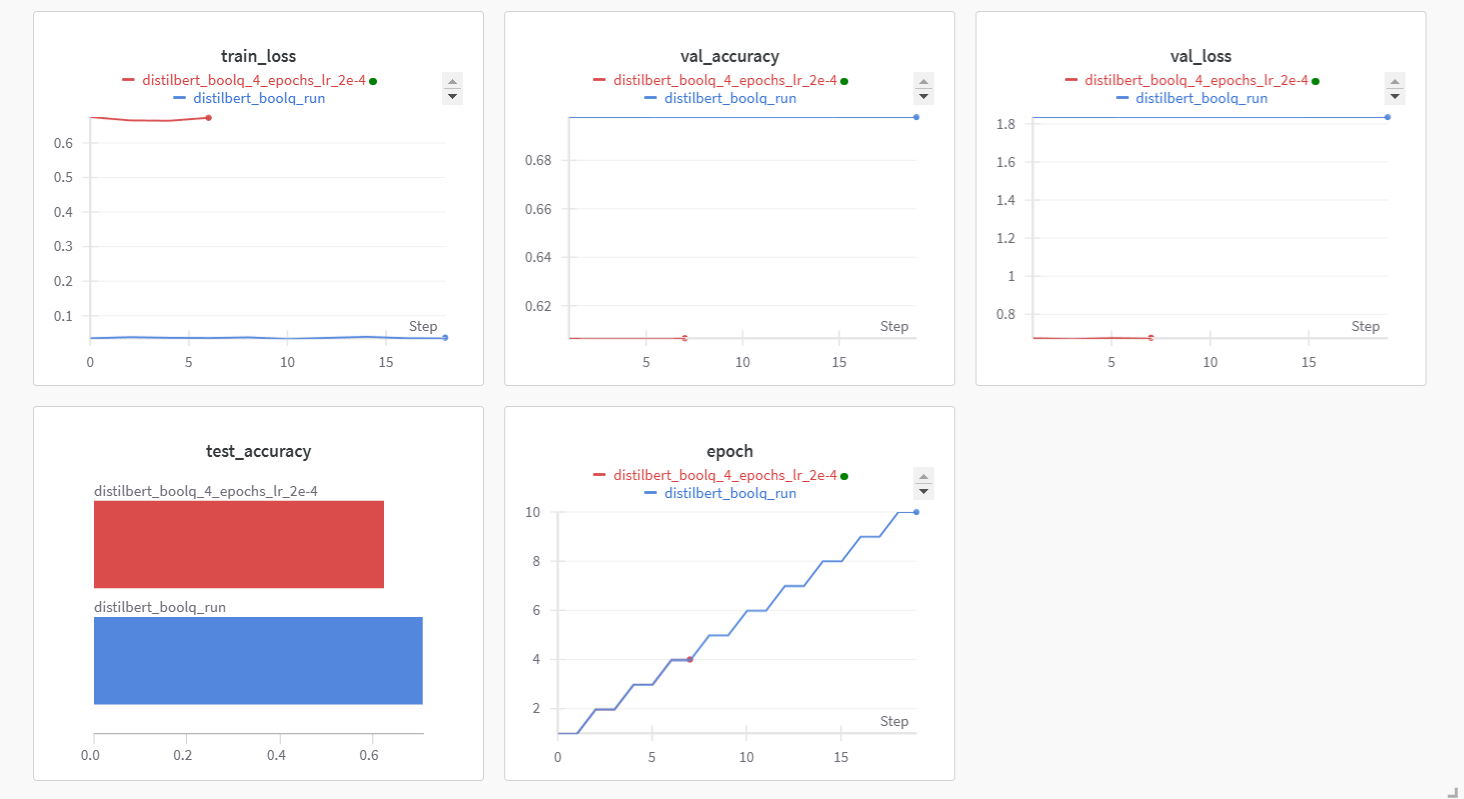